# Code for examining GWAS output

#### E Flynn
#### Last updated: 10/11/2017 

In [1]:
source('mixture_model_scripts/model_utils.R')

Loading required package: MASS
Loading required package: Matrix
Loading required package: mnormt
Loading required package: qqman

For example usage please run: vignette('qqman')

Citation appreciated but not required:
Turner, S.D. qqman: an R package for visualizing GWAS results using Q-Q and manhattan plots. biorXiv DOI: 10.1101/005165 (2014).

Loading required package: rstan
Loading required package: ggplot2
Loading required package: StanHeaders
rstan (Version 2.15.1, packaged: 2017-04-19 05:03:57 UTC, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
rstan_options(auto_write = TRUE)
options(mc.cores = parallel::detectCores())


[1] "Hypothyroidism"


         Sex
Phenotype      F      M
        1 171658 154001
        2   9406   2134

[1] "BMI phenotype distribution"


      ID              Phenotype     Sex       
 Length:336129      Min.   :12.12   F:180525  
 Class :character   1st Qu.:24.16   M:155604  
 Mode  :character   Median :26.75             
                    Mean   :27.42             
                    3rd Qu.:29.88             
                    Max.   :74.68             

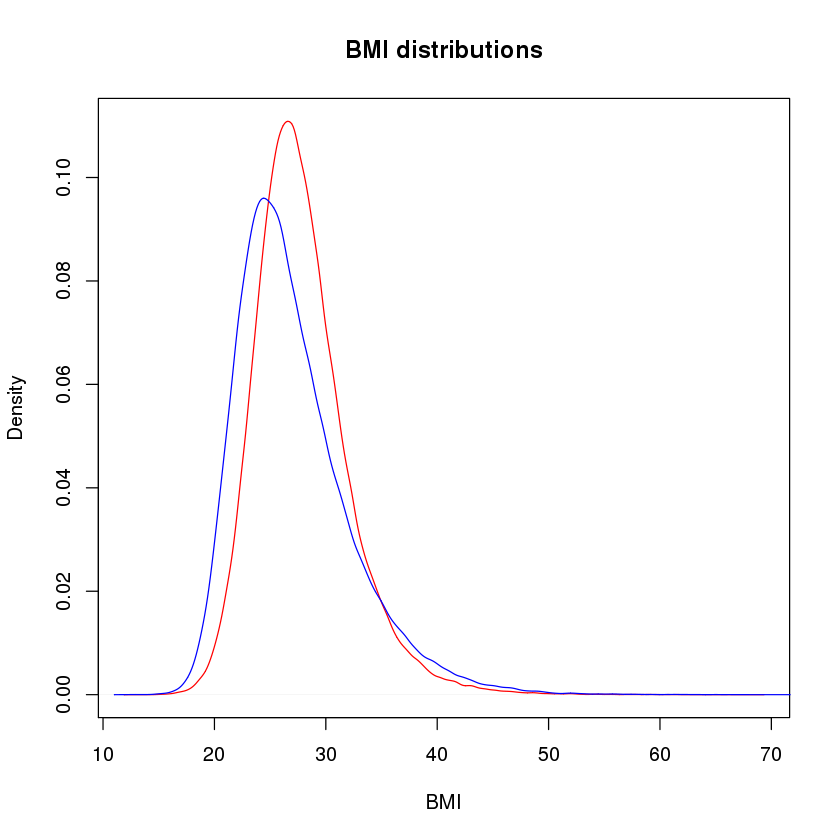

In [10]:
sexLabelPheData <- function(trait){
    
    # load phenotype and sex labels
    pheDat <- read.table(sprintf('phefiles/%s.phe', trait), 
                         colClasses=c("character", "character", "numeric"))
    onesex <- read.table('phefiles/onesex.keep')
    zerosex <- read.table('phefiles/zerosex.keep')
    pheDat2 <- pheDat[,c("V1", "V3")]
    colnames(pheDat2) <- c("ID", "Phenotype")
    rownames(pheDat2) <- pheDat2$ID
    
    # extract m, f rows
    ids.male <- sapply(unlist(onesex$V1[onesex$V1 > 0]), as.character)
    m <- intersect(ids.male, rownames(pheDat2) )
    men <- pheDat2[m,]
    men$Sex <- 'M'
    ids.female <- sapply(unlist(zerosex$V1[zerosex$V1 > 0]), as.character)
    f <- intersect(ids.female, rownames(pheDat2) )
    women <- pheDat2[f,]
    women$Sex <- 'F'
    
    # combine into a full table
    pheFull <- rbind(men, women)
    return(pheFull)
}

# hypothyroidism - note that there are > 3x as many women as many
#  - we regressed out age as part of GWAS analysis - but should we think about this more?
hypoPhe <- sexLabelPheData('RH107')
print("Hypothyroidism")
table(hypoPhe[,c("Phenotype", "Sex")])

# BMI
bmiPhe <- sexLabelPheData('21001') 

print("BMI phenotype distribution")
bmiPhe$Sex <- as.factor(bmiPhe$Sex) # 180k women, 156k women
summary(bmiPhe)
plot(density(bmiPhe[bmiPhe$Sex=='M',]$Phenotype), col='red', main="BMI distributions", xlab='BMI')
lines(density(bmiPhe[bmiPhe$Sex=='F',]$Phenotype), col='blue')


In [12]:
bmiPhe$Sex <- as.factor(bmiPhe$Sex)
colnames(bmiPhe)[2] <- c('BMI')
head(bmiPhe)

,ID,BMI,Sex
2502845,2502845,28.1528,M
5587649,5587649,22.7330,M
1432157,1432157,28.2836,M
3525397,3525397,34.8457,M
6005744,6005744,21.6829,M
4540525,4540525,19.9551,M


In [2]:
phe <- "48"
removeNAs <- function(pheDat, phe){
    # NAs in quantitative data are -9
    print(sprintf("Removed %s missing entries for trait %s.", table(pheDat$V3 == -9)["TRUE"], phe))
    return(pheDat[pheDat$V3 != -9,])
}

phe.path <- sprintf("phefiles/%s.phe", phe)

file.copy(phe.path, sprintf("phefiles/old/%s_v0.phe", phe))
pheDat <- read.table(phe.path)
pheDat.f <- removeNAs(pheDat, phe)
write.table(pheDat.f, file=phe.path, col.names=FALSE, row.names=FALSE, quote=FALSE)

[1] TRUE

[1] "Removed NA missing entries for trait 48."


Warning message:
“Removed 33 rows containing non-finite values (stat_density).”

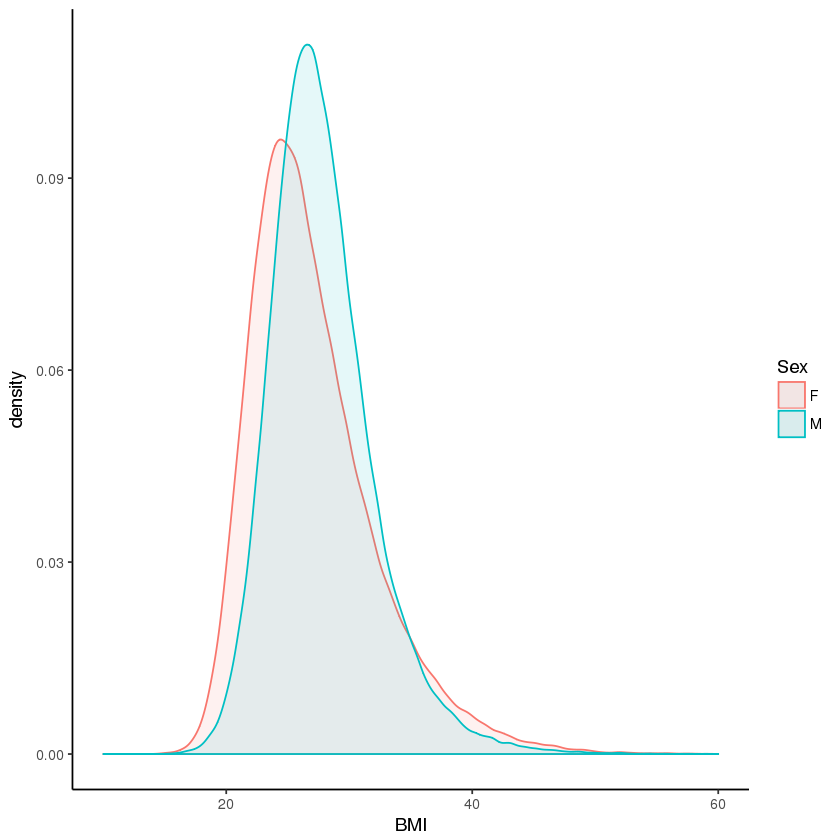

In [18]:
# prettier print BMI phenotype distribution
require('ggplot2')

ggplot(bmiPhe, aes(BMI, fill=Sex, colour=Sex))+ geom_density(alpha=0.1) + xlim(c(10,60))+ theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = "black"))

## Acquired Hypothyroidism

In [17]:
# look at the acquired hypothyroidism data

trait <- 'RH107'

# load all the data
all.dat.h <- lapply(1:22, function(x){ getDataBin(as.character(x), trait)})

# reformat data, remove rows that are not shared
dat.reform.h <- reformatData(all.dat.h, "binary")
dat.f.h <- dat.reform.h$`1`
dat.m.h <- dat.reform.h$`2`



In [18]:
head(dat.f.h)

,CHR,BP,SNP,REF,ALT,FIRTH.,TEST,OBS_CT,OR,SE,T_STAT,P,BETA
9,1,767096,rs115991721,A,G,N,ADD,180742,1.2575548,0.3281980,-0.698264,0.485012,0.229169169
10,1,768448,rs12562034,G,A,N,ADD,180744,0.9938283,0.0246349,0.251308,0.801576,-0.006190797
12,1,779322,rs4040617,A,G,N,ADD,180561,1.0128552,0.0224457,-0.569093,0.569293,0.012773231
13,1,801536,rs79373928,T,G,N,ADD,180949,0.9861738,0.0627573,0.221834,0.824443,-0.013922629
16,1,813034,rs59771807,A,G,N,ADD,180748,0.7956146,0.4578990,0.499321,0.617553,-0.228640416
17,1,834830,rs116452738,G,A,N,ADD,180808,0.9134088,0.0947679,0.955712,0.339218,-0.090571698


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01499 0.03014 0.04586 0.16800 0.07081 2.44000 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.03074 0.06192 0.09425 0.25340 0.14630 2.34100 


 FALSE   TRUE 
  1596 344757 


 FALSE   TRUE 
  2041 344312 

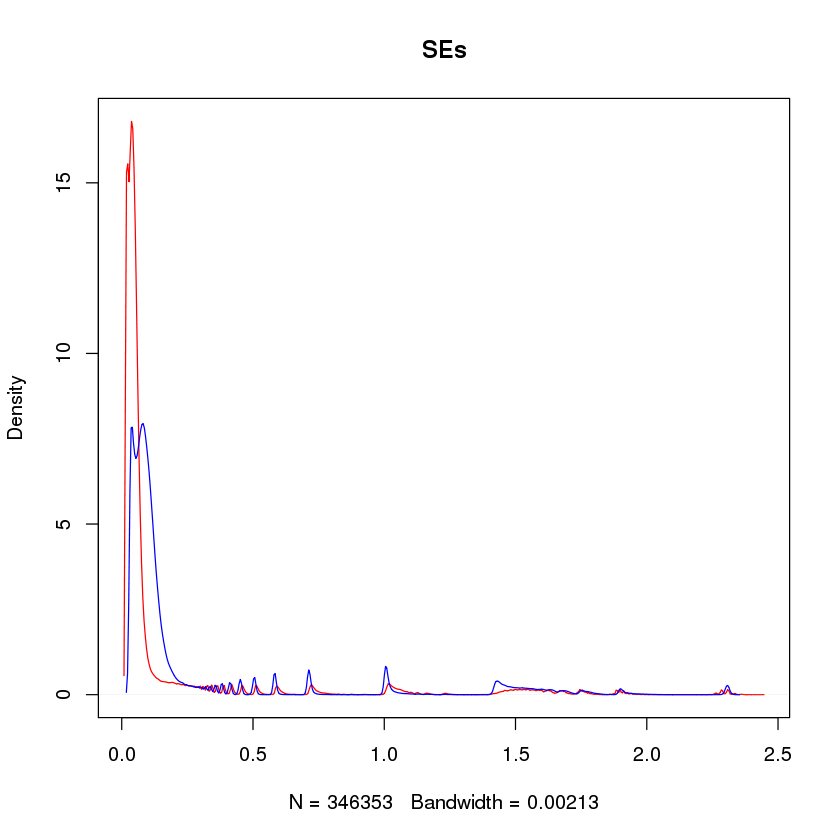

In [31]:
summary(dat.f.h$SE)
summary(dat.m.h$SE)
plot(density(dat.f.h$SE), main='SEs', col='red')
lines(density(dat.m.h$SE), col='blue')

# count how many to remove
table(dat.f.h$SE < 2)
table(dat.m.h$SE < 2)

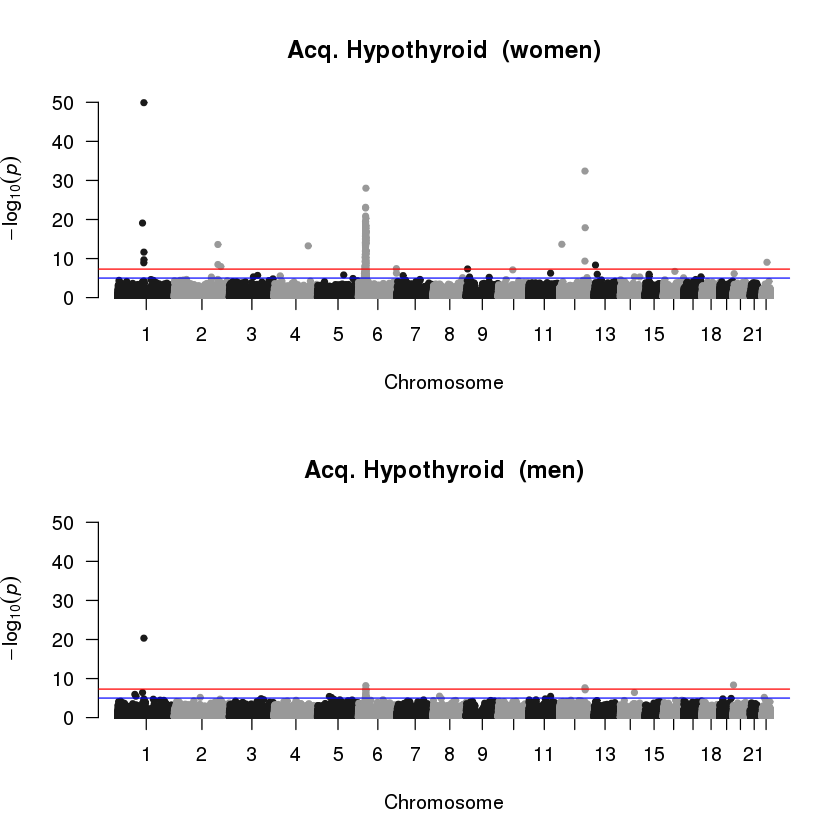

In [4]:
trait.name <- 'Acq. Hypothyroid'
par(mfrow=c(2,1))
    ymax <- ceiling(-log(min(dat.f.h$P, dat.m.h$P), base=10))+1
    manhattan(dat.f.h, main=paste(trait.name, " (women)", sep=" "), ylim=c(0, ymax))
    manhattan(dat.m.h, main=paste(trait.name, " (men)", sep=" "), ylim=c(0, ymax))   

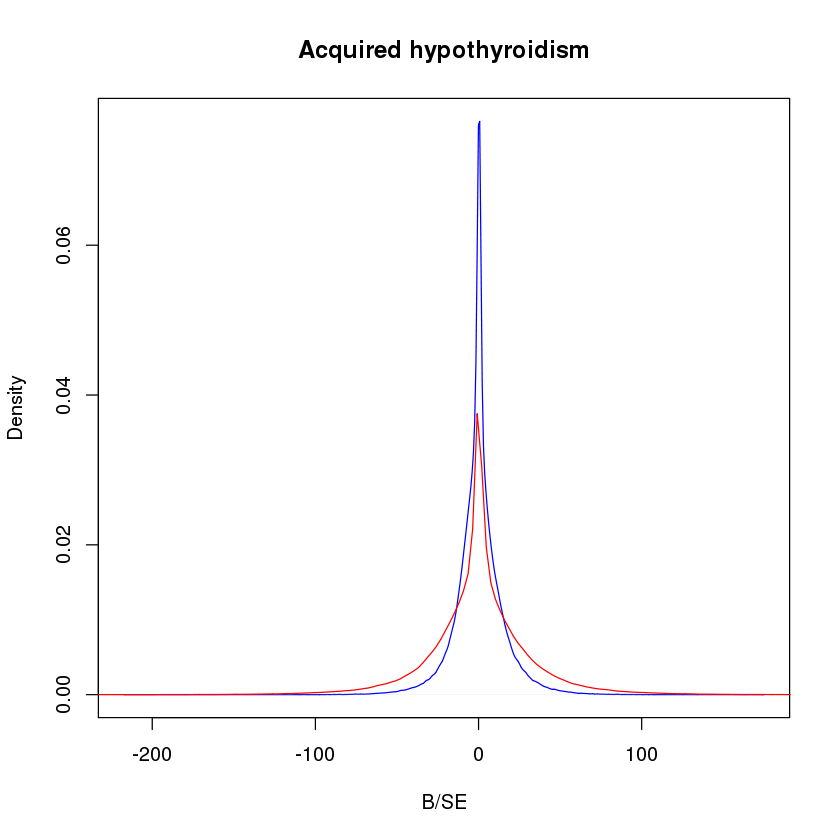

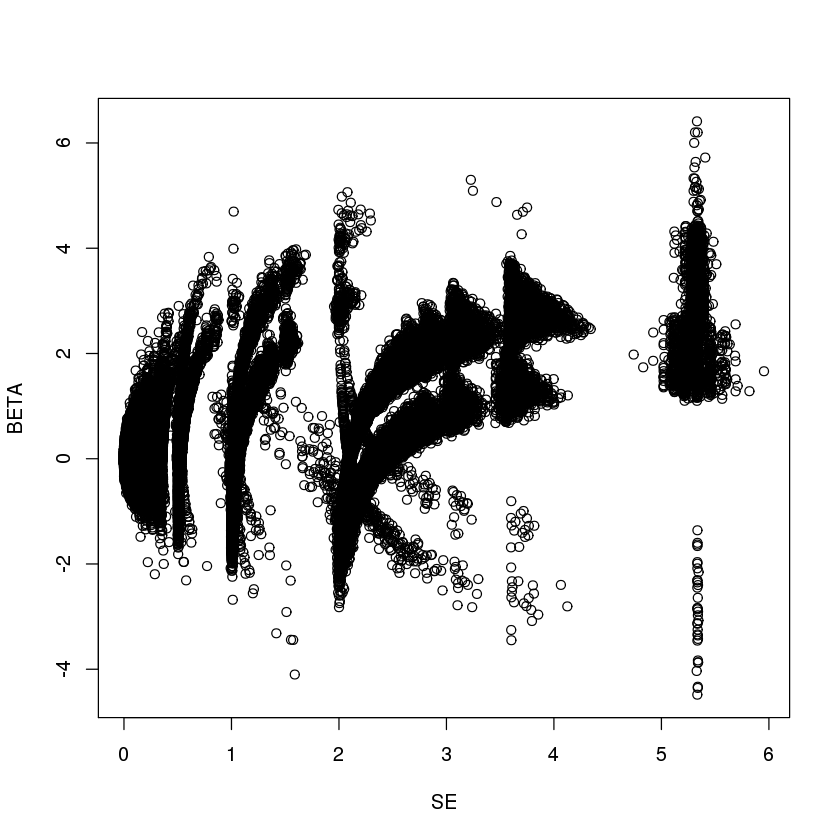

In [20]:
dat.h <- extractDataStan(dat.f.h, dat.m.h)
zplot(dat.h$dat, 'Acquired hypothyroidism')
BSEplot(dat.h$dat)

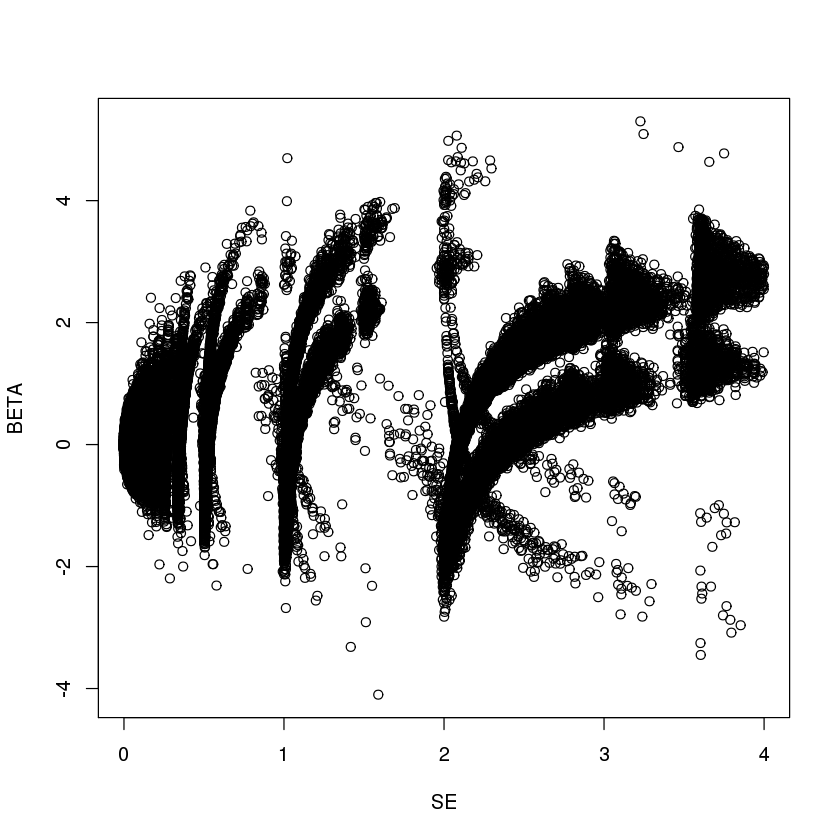

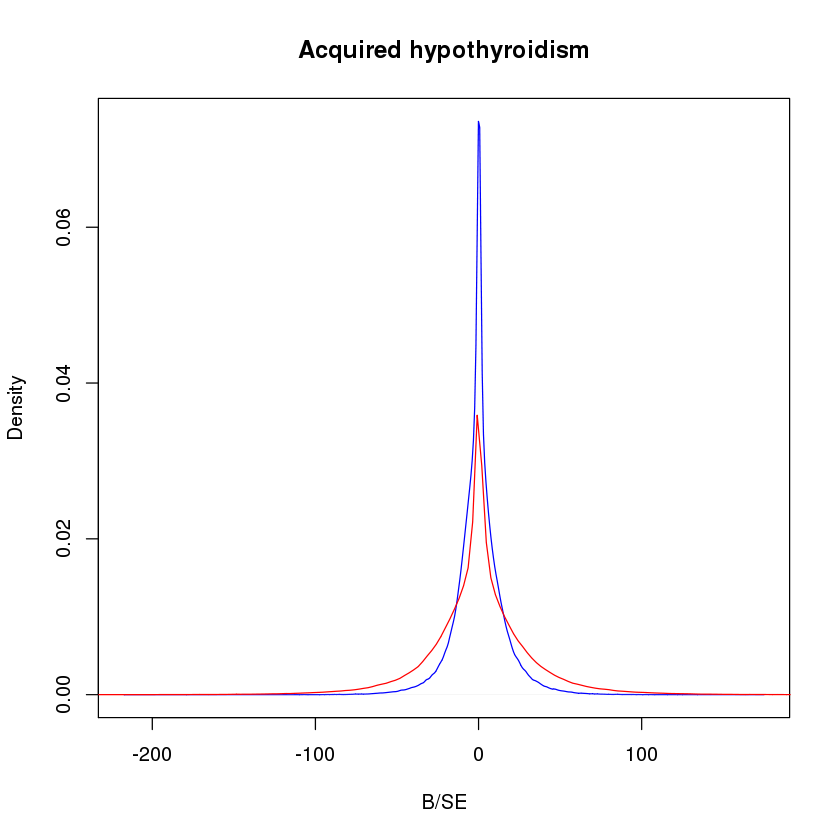

In [30]:
filt.dat.h <- filterSE(dat.f.h, dat.m.h, 'binary')
filt.f.h <-filt.dat.h$`1`
filt.m.h <- filt.dat.h$`2`
dat.filt.h <- extractDataStan(filt.f.h, filt.m.h)

BSEplot(dat.filt.h$dat)
zplot(dat.filt.h$dat, 'Acquired hypothyroidism')

## BMI

In [5]:
trait <- '21001'

# load all the data
all.dat.bmi <- lapply(1:22, function(x){ getData(as.character(x), trait)})

# reformat the data
dat.reform.bmi <- reformatData(all.dat.bmi, "quant")
f.bmi <- dat.reform.bmi$`1`
m.bmi <- dat.reform.bmi$`2`


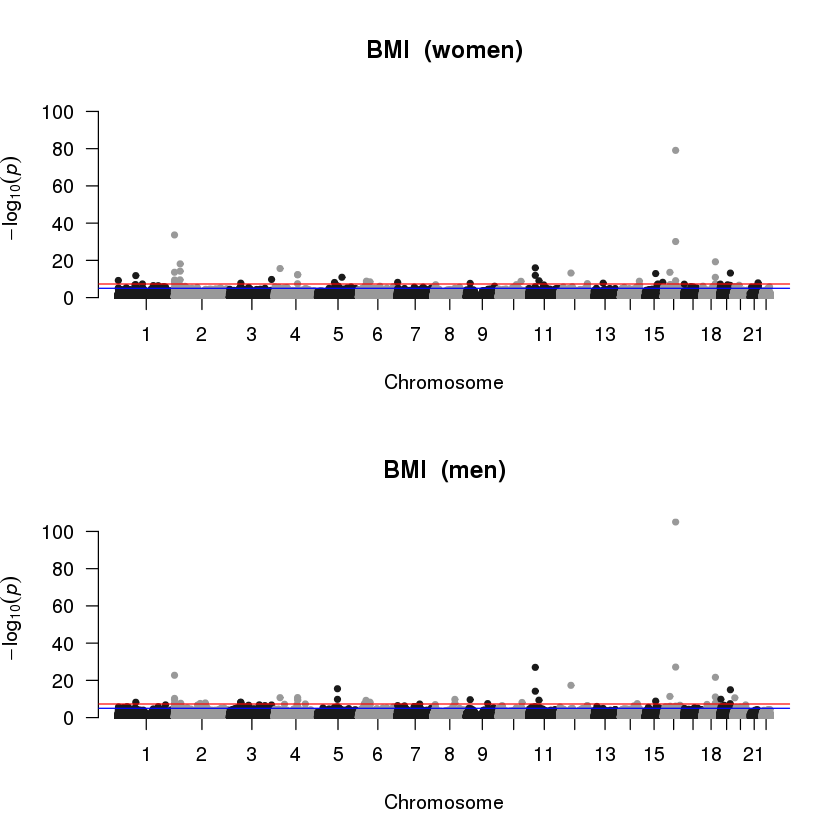

In [5]:
# manhattan plot

trait.name <- 'BMI'
par(mfrow=c(2,1))
ymax <- ceiling(-log(min(f.bmi$P, m.bmi$P), base=10))+1
manhattan(f.bmi, main=paste(trait.name, " (women)", sep=" "), ylim=c(0, ymax))
manhattan(m.bmi, main=paste(trait.name, " (men)", sep=" "), ylim=c(0, ymax))  

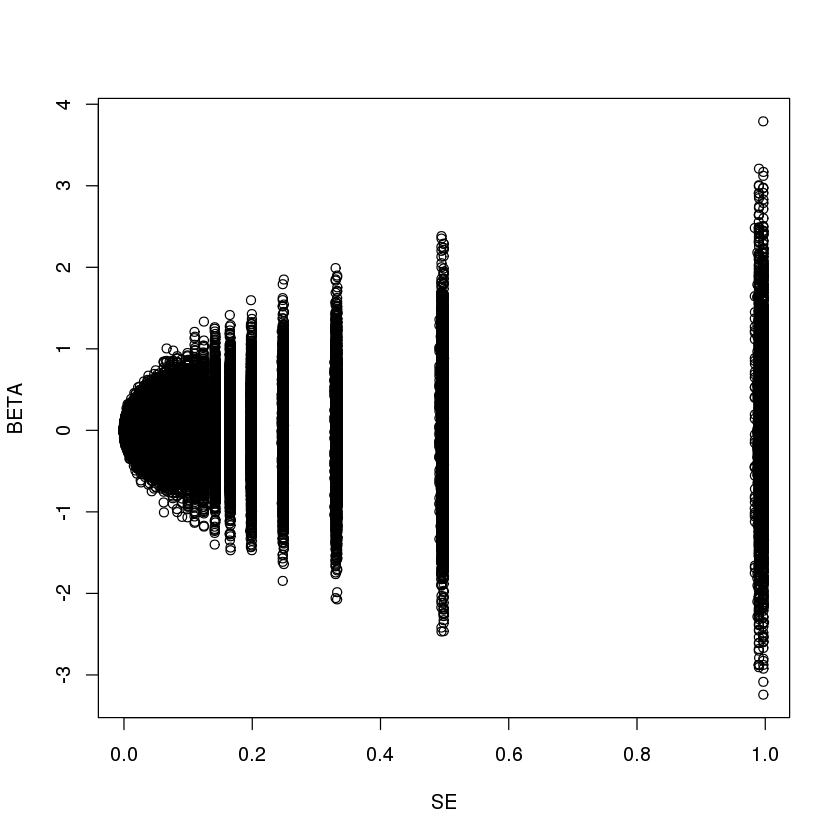

In [6]:
# betas, zs
dat.bmi <- extractDataStan(f.bmi, m.bmi)
BSEplot(dat.bmi$dat)

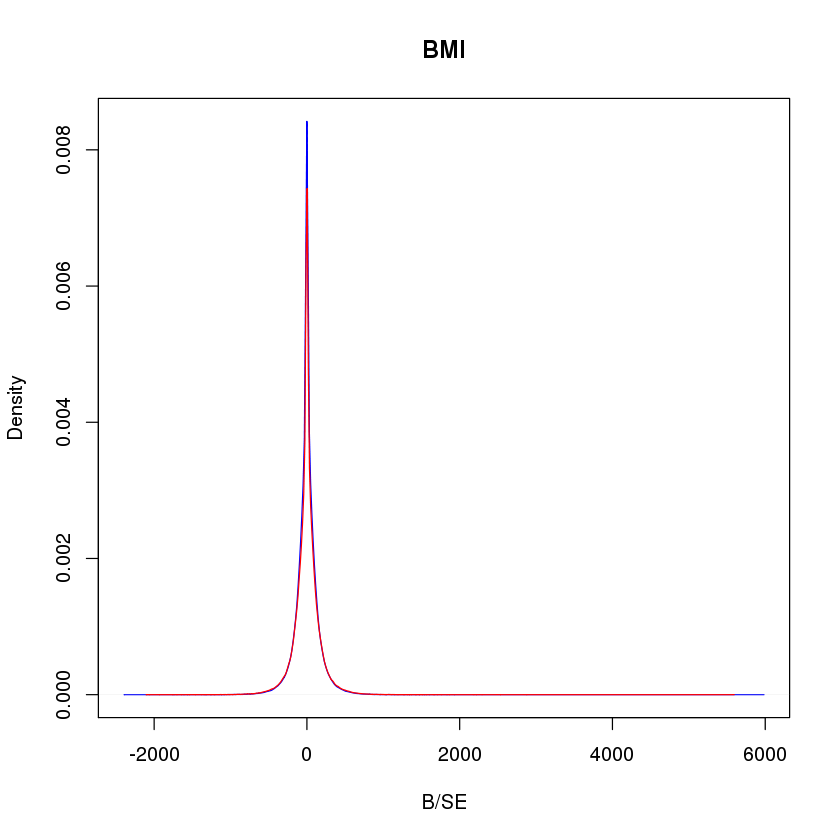

In [14]:
zplot(dat.bmi$dat, 'BMI')

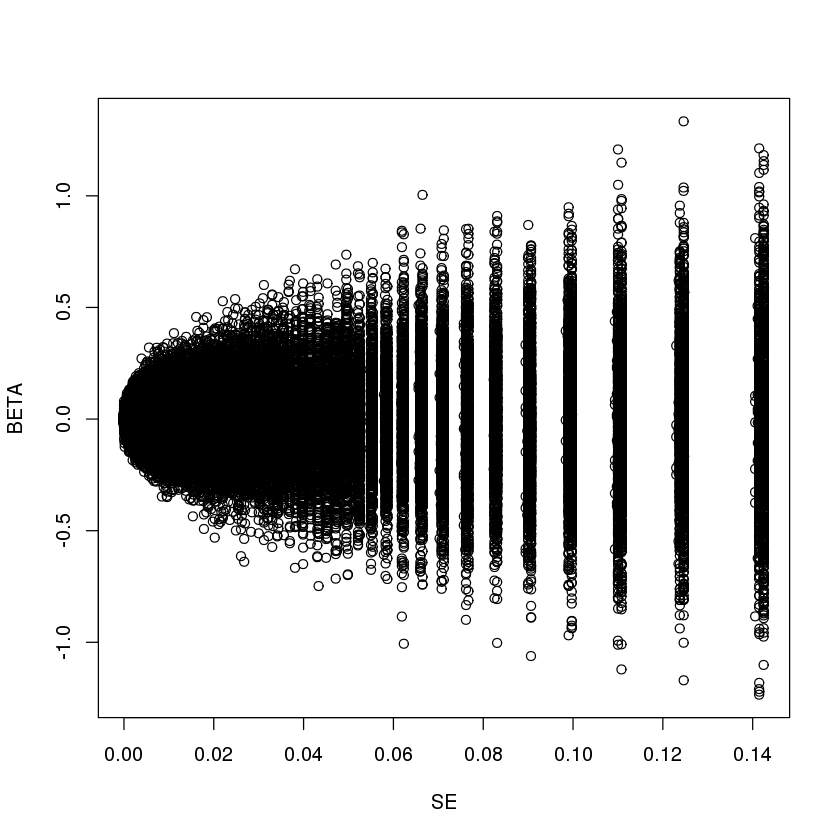

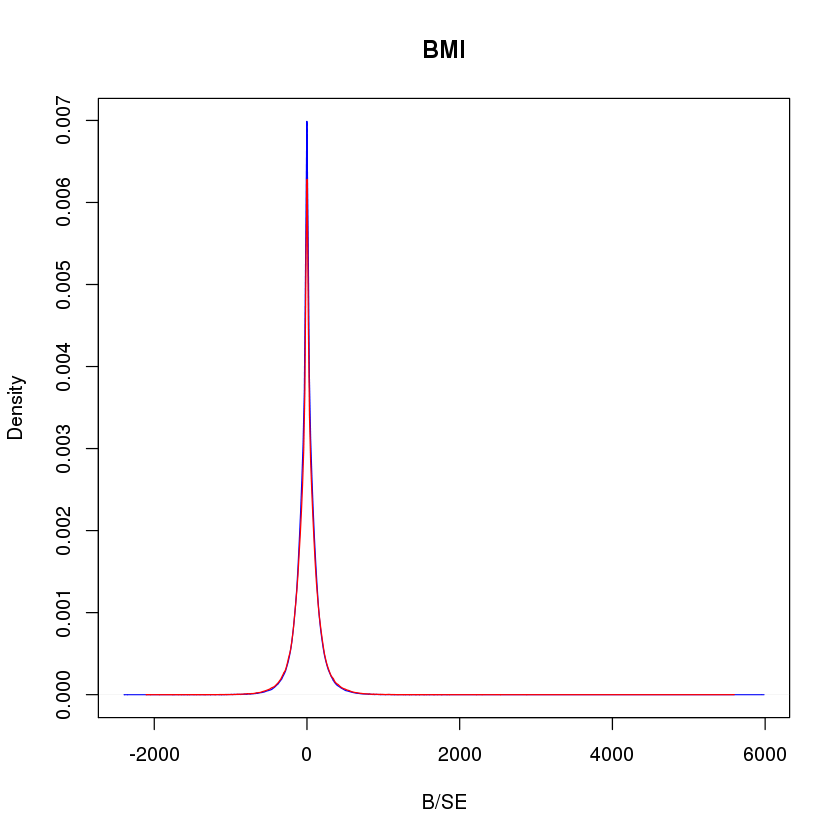

In [15]:
# look at the data with standard error filters

filt.dat.bmi <- filterSE(f.bmi, m.bmi, 'quant')
filt.f.bmi <-filt.dat.bmi$`1`
filt.m.bmi <- filt.dat.bmi$`2`
dat.filt.bmi <- extractDataStan(filt.f.bmi, filt.m.bmi)

BSEplot(dat.filt.bmi$dat)
zplot(dat.filt.bmi$dat, 'BMI')